In [1]:
import os
import numpy as np
import scipy
import scipy.linalg

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datadir = "../data"

In [3]:
weights_file = os.path.join(datadir, "DHFR.weights.npy")

if os.path.isfile(weights_file):
    weights = np.load(weights_file)
    print("Loading weights from : ", weights_file)

single_site_marginal_file = os.path.join(datadir, "DHFR.single.npy")
double_site_marginal_file = os.path.join(datadir, "DHFR.double.npy")

if os.path.isfile(double_site_marginal_file) and os.path.isfile(single_site_marginal_file):
    f_i_a = np.load(single_site_marginal_file)
    print("Loading single site marginals from ", single_site_marginal_file)

    f_i_j_a_b = np.load(double_site_marginal_file)
    print("Loading double site marginals from ", double_site_marginal_file)    

Loading weights from :  ../data/DHFR.weights.npy
Loading single site marginals from  ../data/DHFR.single.npy
Loading double site marginals from  ../data/DHFR.double.npy


In [4]:
AMINO_ACIDS = np.array([aa for aa in "RKDEQNHSTCYWAILMFVPG-"], "S1")

In [5]:
L, q = f_i_a.shape

M_eff = sum(weights)

In [6]:
# Add pseudo count
pseudo_count_ratio = 0.5

f_i_a = (pseudo_count_ratio / q ) + (1 - pseudo_count_ratio) * f_i_a / M_eff
f_i_j_a_b = (pseudo_count_ratio  / (q*q) ) + (1 - pseudo_count_ratio) * f_i_j_a_b / M_eff

# The formula for f_i_j_a_b is a little different when i==j
# essentially we have f_i_a on the diagonal and zero's everywhere else. 
for i in range(L):
    f_i_j_a_b[i, :, i, :] = np.diag(f_i_a[i, :])

In [7]:
# Covariance Matrix
# We take an outer product of f_i_a with itself using numpy's broadcasting rules. 
# This gives us a matrix where the (i,a, j, b) index is f[i,a] * f[j,b]
C_i_j_a_b = f_i_j_a_b  - f_i_a[:, :, np.newaxis, np.newaxis] * f_i_a[np.newaxis, np.newaxis, :, :] 

# we project the covariance matrix down the first q-1 elements
# Since the frequencies add up to 1 we can discard amino-acid value (a = q) for each site
# without losing any information
C_i_j_a_b = C_i_j_a_b[:, :(q-1), :, :(q-1)]
print("C_i_j_a_b.shape = {}".format(C_i_j_a_b.shape)) 

# delete the frequency matrices now that we have a covariance matrix.
#del f_i_a, f_i_j_a_b

C_i_j_a_b.shape = (186, 20, 186, 20)


In [8]:
cov = C_i_j_a_b.reshape((L*(q-1), L*(q-1)))

In [9]:
invCov = np.linalg.inv(cov)
e_i_j_a_b =  - invCov.reshape((L, q-1, L, q-1))
etilde_i_j_a_b = e_i_j_a_b - e_i_j_a_b.mean(axis=3, keepdims=True) - \
        e_i_j_a_b.mean(axis=1, keepdims=True) + \
        e_i_j_a_b.mean(axis=3, keepdims=True).mean(axis=1, keepdims=True)

F_i_j = np.linalg.norm(etilde_i_j_a_b, ord="fro", axis=(1,3))

In [10]:
# Read in the data file
msa_file = os.path.join(datadir, "DHFR.aln")
# Read all the lines in the file into a 2D array of type S1
with open(msa_file) as fh:
    arr = np.array([[x for x in line.strip()] for line in fh], np.dtype("S1"))

print("shape =", arr.shape, ",dtype= ", arr.dtype)

shape = (56165, 186) ,dtype=  |S1


In [11]:
M, L = arr.shape

proj_data = np.zeros(arr.shape, dtype=np.float)

for a in AMINO_ACIDS:
    proj_data = np.where(arr == a, np.squeeze(f_i_a[:, AMINO_ACIDS==a]), proj_data)

normalizer = np.linalg.norm(f_i_a, axis=1)

proj_data = proj_data / normalizer

In [12]:
compressed_cov = np.cov(proj_data, aweights=weights, bias=True, rowvar=False)

In [13]:
neg_inv_compressed_cov = - np.linalg.inv(compressed_cov[10:, 10:])

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

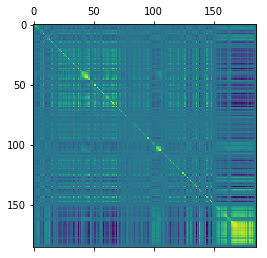

In [15]:
plt.matshow(compressed_cov)

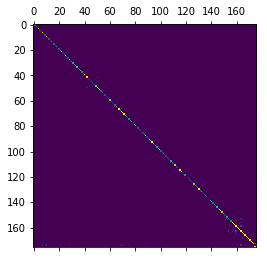

In [16]:
x = np.clip(neg_inv_compressed_cov, np.percentile(neg_inv_compressed_cov, 0.1), 
                         np.percentile(neg_inv_compressed_cov, 0.9))
#np.fill_diagonal(x, 0.)
plt.matshow(-x)

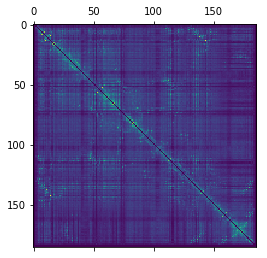

In [17]:
np.fill_diagonal(F_i_j, 0)
plt.matshow(F_i_j)